In [21]:
import numpy as np
import nibabel as nib
from math import ceil
from matplotlib import pyplot as plt
from skimage.measure import shannon_entropy
import warnings
warnings.simplefilter('ignore')

In [2]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]

In [3]:
# Plot parameters
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [4]:
# Flat the vector
t1 = t1_slice.flatten().astype(np.float16)
t2 = t2_slice.flatten().astype(np.float16)

In [5]:
n, m = t1_slice.shape

# Empiric copula
The calculation of this is necessary for the adjustment of an anlytic copula.
$C_n(\frac{i}{n}, \frac{j}{m}) = \frac{\# x \leq x_{(i)} \& y \leq y_{(i)}}{n}$

In [6]:
def em_copula(x,y):
    n = len(x)
    _xy = np.vstack((x,y)).T.reshape(n,2,1,1)
    _xy_sorted = np.stack((
        np.sort(x) + np.zeros((n,n)),
        (np.sort(y) + np.zeros((n,n))).T
    )).reshape(1,2,n,n)
    return np.all(_xy <= _xy_sorted, axis = 1).sum(axis = 0).T

This runs out of memory for our test images (and probably for all of the images we try)

In [ ]:
em_copula(t1,t2)

## Smoothing
This process will reduce the size of the image by a factor of $\varepsilon$, making the data more manageable

In [7]:
e = 0.5
# New size of the array
alpha = ceil(n*e)
beta = ceil(m*e)
# New image
n_t1 = np.zeros((alpha,beta))
# Size of the window
ne = ceil(n/alpha)
me = ceil(m/beta)

In [8]:
# Resizing
for i in range(alpha-1):
    for j in range(beta-1):
        n_t1[i,j] = np.mean(t1_slice[i*ne:(i+1)*ne, j*me: (j+1)*me])

### Original image
This is how the original image looks like

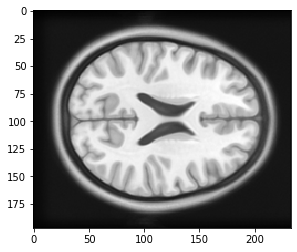

In [9]:
plt.imshow(t1_slice)
plt.show()

### Smoothed image
This is the image after a reduction of half 

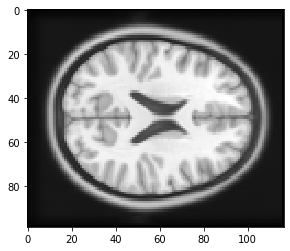

In [10]:
plt.imshow(n_t1)
plt.show()

They look very similar, don't they? But, how well does this final image represent the data? Let's find out by using the entropy measure

In [11]:
def smoothing(image, epsilon):
    n, m = image.shape
    # New size of the array
    alpha = ceil(n*epsilon)
    beta = ceil(m*epsilon)
    # New image
    n_image = np.zeros((alpha,beta))
    # Size of the window
    ne = ceil(n/alpha)
    me = ceil(m/beta)
    # Resizing
    for i in range(alpha-1):
        for j in range(beta-1):
            n_image[i,j] = np.mean(image[i*ne:(i+1)*ne, j*me: (j+1)*me])
    return n_image

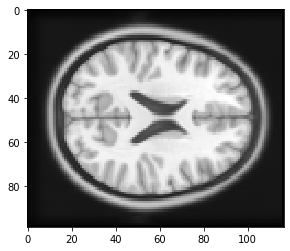

In [12]:
plt.imshow(smoothing(t1_slice, 0.5))
plt.show()

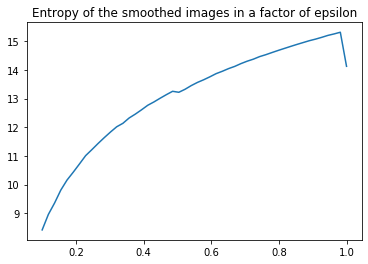

In [22]:
plt.plot(np.linspace(0.1,1,50),[shannon_entropy(smoothing(t1_slice, i)) for i in np.linspace(0.1,1,50)])
plt.title('Entropy of the smoothed images in a factor of epsilon')
plt.show()

### Redefinition of the images
Using the smoothing, we will select a smaller sample

In [14]:
n_t1 = smoothing(t1_slice, 0.2).flatten()
n_t2 = smoothing(t2_slice, 0.2).flatten()

In [15]:
from copulas.bivariate import select_copula

## Copula fitting
Some built-in methods in Python use the empiric copula to compare against some known copulas and select the best fit using the kendall tau

In [23]:
copula = select_copula(np.vstack((n_t1,n_t2)))
copula.fit(np.vstack((n_t1,n_t2)))
copula.to_dict()

{'copula_type': 'CLAYTON', 'theta': inf, 'tau': 1.0}

However, they may not be the best option.

In [24]:
from tqdm import tqdm

In [25]:
def empirical(X,Y):
    n = len(X)
    XY = np.vstack((X,Y)).T
    sort_x = np.sort(X)
    sort_y = np.sort(Y)
    e_copula = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            c = np.sum(np.where( (np.sum(np.where((XY <= [sort_x[i],sort_y[j]]), 1, 0), axis = 1)) == 2, 1, 0))
            e_copula[i,j] = c/n
    return e_copula    

In [26]:
a = empirical(n_t1,n_t2)

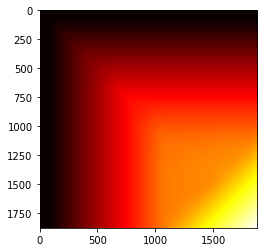

In [27]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [30]:
from scipy.stats import invgamma, chi2, t
from scipy.linalg import cholesky

## T-student copula
Can be simulated as a extreme value copula

In [63]:
# Define a correlation matrix, the p is a parameter
cm = np.array([[1,0.4],[0.4,1]])
# Find the cholesky matrix
L = cholesky(cm)
# The number of samples to draw from the copula
n = 1000
# Zero mean
mu = np.zeros(len(cm))
# Multivariate normal
Y = np.random.multivariate_normal(mu, cm, n)
# Degrees of freedom of the t-student copula
df = 40
# Simulate a chi squared
S = chi2.rvs(df, n)
Z = np.sqrt(df/S)*L@Y.T
# Simulated copula
U = t.cdf(df, Z)

In [64]:
b = empirical(U[0],U[1])

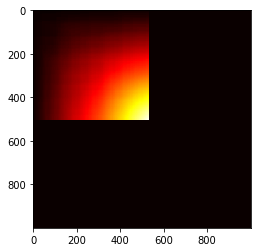

In [65]:
plt.imshow(b, cmap = 'hot')
plt.show()